# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings

In [2]:
import sys
sys.path.append('..')  # Replace with the actual path to ROOT

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
#ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [4]:
path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [5]:
# load transaction dataset
df_patients = pd.read_csv(path_patients)
df_admissions = pd.read_csv(path_admissions)
df_diagnoses_icd = pd.read_csv(path_diagnoses_icd)
df_labevents = pd.read_csv(path_labevents)
df_microbiologyevents = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd = pd.read_csv(path_desc_icd)
df_desc_labitems = pd.read_csv(path_desc_labitems)
df_desc_items = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [6]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

ValueError: unconverted data remains when parsing with format "%Y-%m-%d": " 00:00:00", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [6]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [11]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd[(df_diagnoses_icd['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

In [41]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic = pd.read_csv(pathname_demographic)
    df_demographic['ADMITTIME'] = pd.to_datetime(df_demographic['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
    df_demographic['DISCHTIME'] = pd.to_datetime(df_demographic['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = ((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365).dt.days
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)

In [ ]:
# create age category 
df_demographic = util.categorise_age(df_demographic)

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of sepsis admissions is: 67
The median age of non-sepsis admissions is: 61


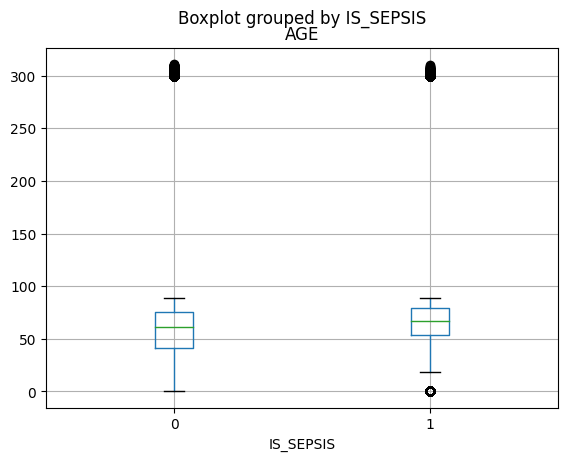

In [43]:
# plotting the age of admissions
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
sepsis_median_age = int(df_demographic[df_demographic.IS_SEPSIS==1]['AGE'].median())
nonsepsis_median_age = int(df_demographic[df_demographic.IS_SEPSIS==0]['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of sepsis admissions is: {}'.format(sepsis_median_age))
print('The median age of non-sepsis admissions is: {}'.format(nonsepsis_median_age))

We replace those with aged > 100 of sepsis/non-sepsis by the median age of sepsis patient (67) and non-sepsis patient (61) respectively

In [44]:
df_demographic.loc[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS == 1), 'AGE'] = sepsis_median_age
df_demographic.loc[(df_demographic.AGE>100) & (df_demographic.IS_SEPSIS == 0), 'AGE'] = nonsepsis_median_age

Load unpivoted labevents dataframe:

In [15]:
# List all Parquet files in the output folder
output_dir = ROOT_DIR / 'data' / 'labevents_transform_sepsis_parquet'
parquet_files = [f'{output_dir}/{file}' for file in os.listdir(output_dir) if file.endswith('.parquet')]

# Read all Parquet files into a list of DataFrames
dfs = [pd.read_parquet(file) for file in parquet_files]

# Concatenate the list of DataFrames into a single DataFrame
df_labevents_sepsis = pd.concat(dfs, ignore_index=True)
df_labevents_sepsis.columns = df_labevents_sepsis.columns.str.upper()

Load unpivoted labevents dataframe:

In [46]:
df_labevents_processed = load_parquet.load_labevents_dask(ROOT_DIR)

2023-09-04 21:19:43.828182 Start
2023-09-04 21:19:44.130694 2045381
2023-09-04 21:19:46.751229 End


In [ ]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents[df_labevents['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents[pd.to_numeric(df_labevents["HADM_ID"], errors='coerce').notnull()]

df_admissions.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

#Uncomment these if you want to export to CSV
# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

In [ ]:
# FINAL these three together is the total lab_events len(df_filled_hadm_labevents) + len(filtered_data_hasHADM) + len(filtered_data_noHADM)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)
combined_df_hasHADM

## 1.2 Data Exploration

In [7]:
# subset of labevents
df_labevents_s = df_labevents.head(10000).copy()
df_labevents_s

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
...,...,...,...,...,...,...,...,...,...
9995,9775,21,109451.0,51221,2134-09-21 05:40:00,28.9,28.90,%,abnormal
9996,9776,21,109451.0,51222,2134-09-21 05:40:00,9.1,9.10,g/dL,abnormal
9997,9777,21,109451.0,51237,2134-09-21 05:40:00,1.9,1.90,NaN,NaN
9998,9778,21,109451.0,51248,2134-09-21 05:40:00,27.9,27.90,pg,NaN


In [ ]:
df_labevents_s.VALUEUOM

In [57]:

df_labevents_s.dropna(subset=['HADM_ID', 'VALUENUM']).groupby(['HADM_ID', 'ITEMID'])['VALUENUM'].mean().reset_index()
# we have a lot of ITEMID values with 0
df_labevents_s[(df_labevents_s['HADM_ID']==112213) & (df_labevents_s['ITEMID']==51143)]
# are these categorical variables?
# how do we identify these...


,HADM_ID,ITEMID,VALUENUM
0,103251.0,51143,0.000000
1,103251.0,51144,0.000000
2,103251.0,51146,0.000000
3,103251.0,51200,1.000000
4,103251.0,51221,51.400000
...,...,...,...
862,194540.0,51277,13.900000
863,194540.0,51279,4.267368
864,194540.0,51301,9.857895
865,194540.0,51491,5.000000


In [71]:
len(df_labevents['ITEMID'].unique())

726

In [91]:

def check_value_type(value):
    try:
        num_value = float(value)
        if num_value.is_integer():
            return 'Integer'
        else:
            return 'Continuous'
    except ValueError:
        return 'Categorical'
    

# Apply the function to the VALUE column
df_labevents_s['Value_Type'] = df_labevents_s['VALUE'].apply(check_value_type)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,Value_Type
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN,Continuous
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN,Categorical
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN,Integer
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN,Integer
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal,Continuous
...,...,...,...,...,...,...,...,...,...,...
9995,9775,21,109451.0,51221,2134-09-21 05:40:00,28.9,28.90,%,abnormal,Continuous
9996,9776,21,109451.0,51222,2134-09-21 05:40:00,9.1,9.10,g/dL,abnormal,Continuous
9997,9777,21,109451.0,51237,2134-09-21 05:40:00,1.9,1.90,NaN,NaN,Continuous
9998,9778,21,109451.0,51248,2134-09-21 05:40:00,27.9,27.90,pg,NaN,Continuous


In [100]:
# 84 in our subset are categorical
df_labevents_s[df_labevents_s['Value_Type'] == 'Categorical'].groupby('ITEMID').nunique()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,Value_Type
ITEMID,,,,,,,,,
50800,169,12,13,169,3,0,0,0,1
50812,79,10,11,79,2,0,0,0,1
50827,51,8,8,51,26,0,0,0,1
50828,35,7,8,35,3,0,0,0,1
50854,3,2,0,3,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
51514,42,12,8,42,1,0,2,0,1
51516,19,11,6,19,6,0,1,1,1
51518,2,1,1,2,2,0,0,0,1


In [101]:
df_labevents_s['CHARTTIME'] = pd.to_datetime(df_labevents_s['CHARTTIME'])
df_labevents_s.groupby('SUBJECT_ID').resample('6H', on='CHARTTIME').mean()

#Resampling LABEVENTS data to 6-hour intervals
#df_labevents_s['CHARTTIME'] = pd.to_datetime(df_labevents_s['CHARTTIME'])

#df_labevents_s.groupby('SUBJECT_ID').mean()

#Find ITEMID mean value

TypeError: agg function failed [how->mean,dtype->object]

In [123]:
import src.basic_vis as basicvis
reload(basicvis)

<module 'src.basic_vis' from '/Users/alexturner/CITS5553/Project/data-science-capstone-project/src/basic_vis.py'>

TypeError: Cannot convert ['units' 'mEq/L' 'mEq/L' ... 'g/dL' 'pg' '%'] to numeric

<Figure size 1300x600 with 0 Axes>

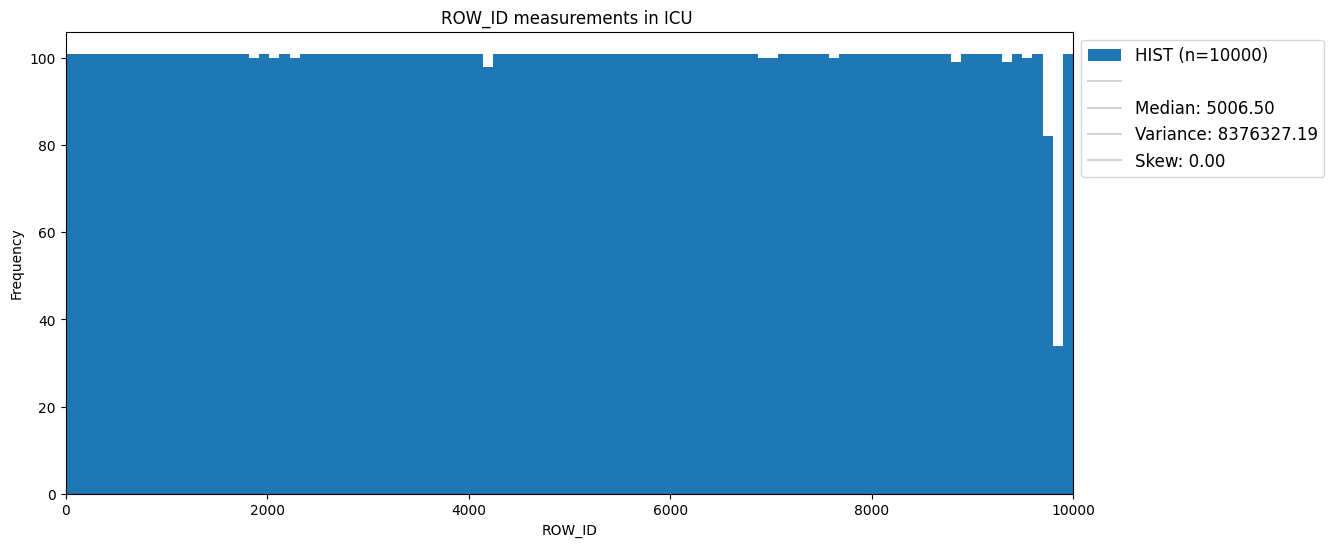

<Figure size 1300x600 with 0 Axes>

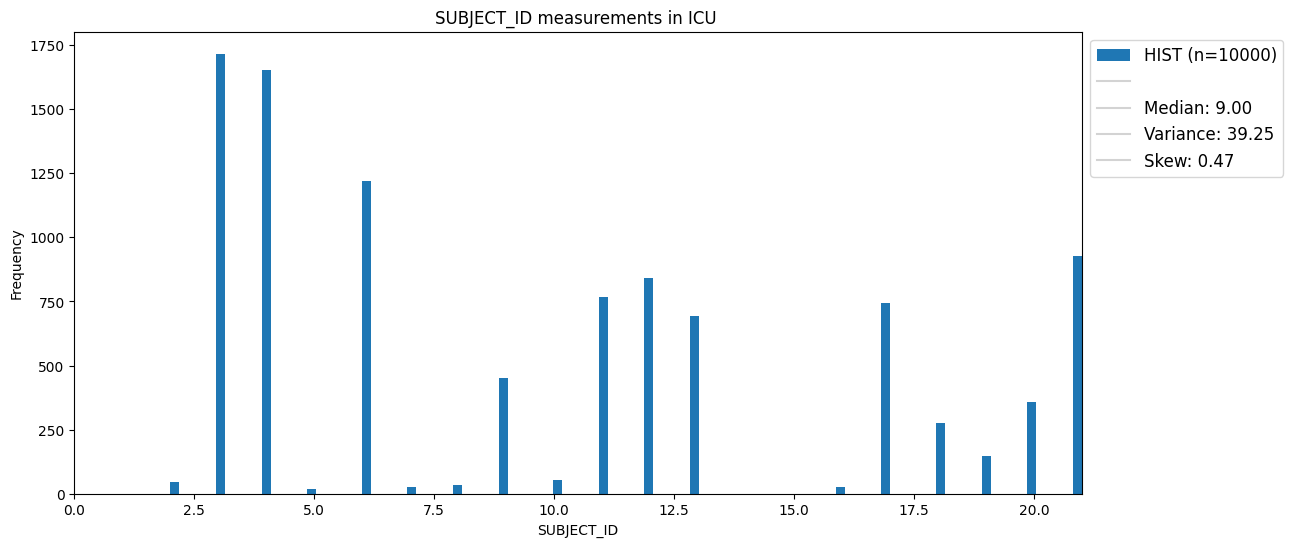

<Figure size 1300x600 with 0 Axes>

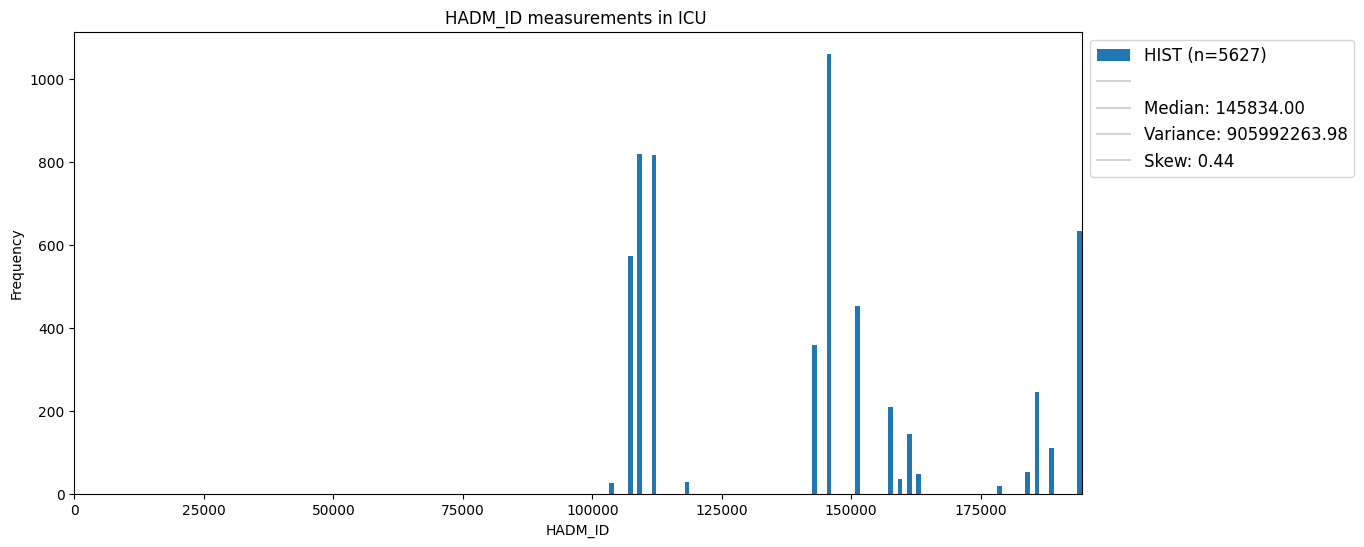

<Figure size 1300x600 with 0 Axes>

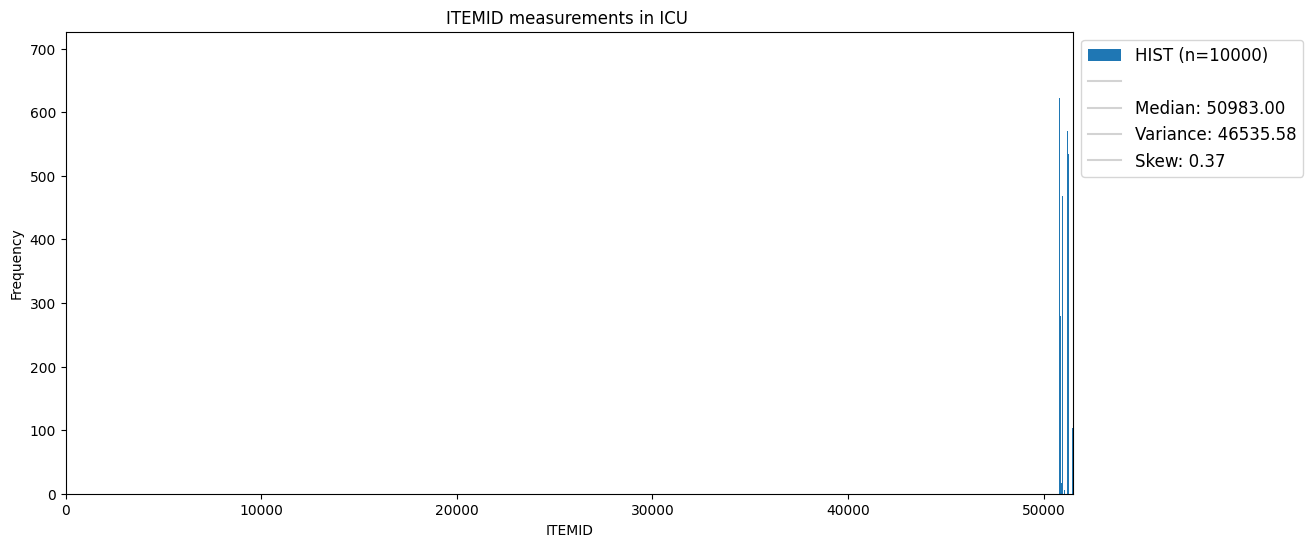

<Figure size 1300x600 with 0 Axes>

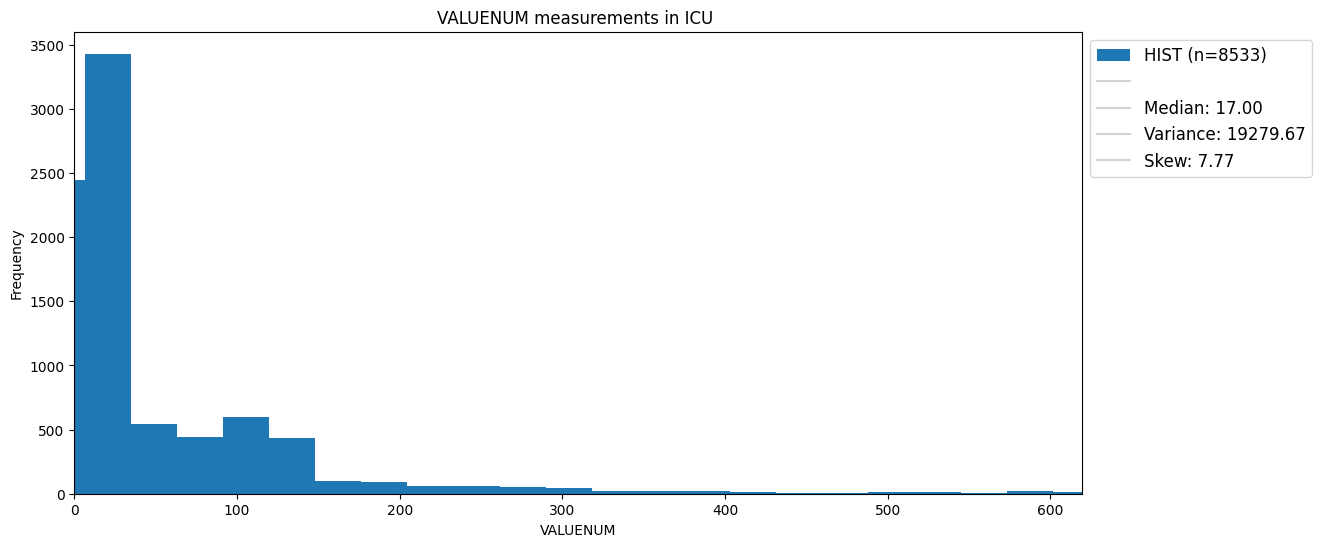

In [124]:
basicvis.plot_variable_histograms(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM', 'VALUEUOM'], df_labevents_s)

In [125]:
df_labevents_s

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,Value_Type
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN,Continuous
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN,Categorical
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN,Integer
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN,Integer
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal,Continuous
...,...,...,...,...,...,...,...,...,...,...
9995,9775,21,109451.0,51221,2134-09-21 05:40:00,28.9,28.90,%,abnormal,Continuous
9996,9776,21,109451.0,51222,2134-09-21 05:40:00,9.1,9.10,g/dL,abnormal,Continuous
9997,9777,21,109451.0,51237,2134-09-21 05:40:00,1.9,1.90,NaN,NaN,Continuous
9998,9778,21,109451.0,51248,2134-09-21 05:40:00,27.9,27.90,pg,NaN,Continuous


In [114]:
df_labevents_s.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE',
       'VALUENUM', 'VALUEUOM', 'FLAG', 'Value_Type'],
      dtype='object')

## 1.3 Feature Selection

In [12]:
NAmask = df_microbiologyevents.notna()

# Use the mask to filter the DataFrame
df_microbiologyevents[NAmask].head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,744,96,170324,2156-04-13 00:00:00,2156-04-13 14:18:00,70021.0,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,745,96,170324,2156-04-20 00:00:00,2156-04-20 13:10:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746,96,170324,2156-04-20 00:00:00,2156-04-20 16:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,747,96,170324,2156-04-20 00:00:00,NaN,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748,96,170324,2156-04-20 00:00:00,NaN,70079.0,URINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


In [ ]:
df_labevents_processed = load_parquet.load_labevents_dask(ROOT_DIR)

<Axes: >

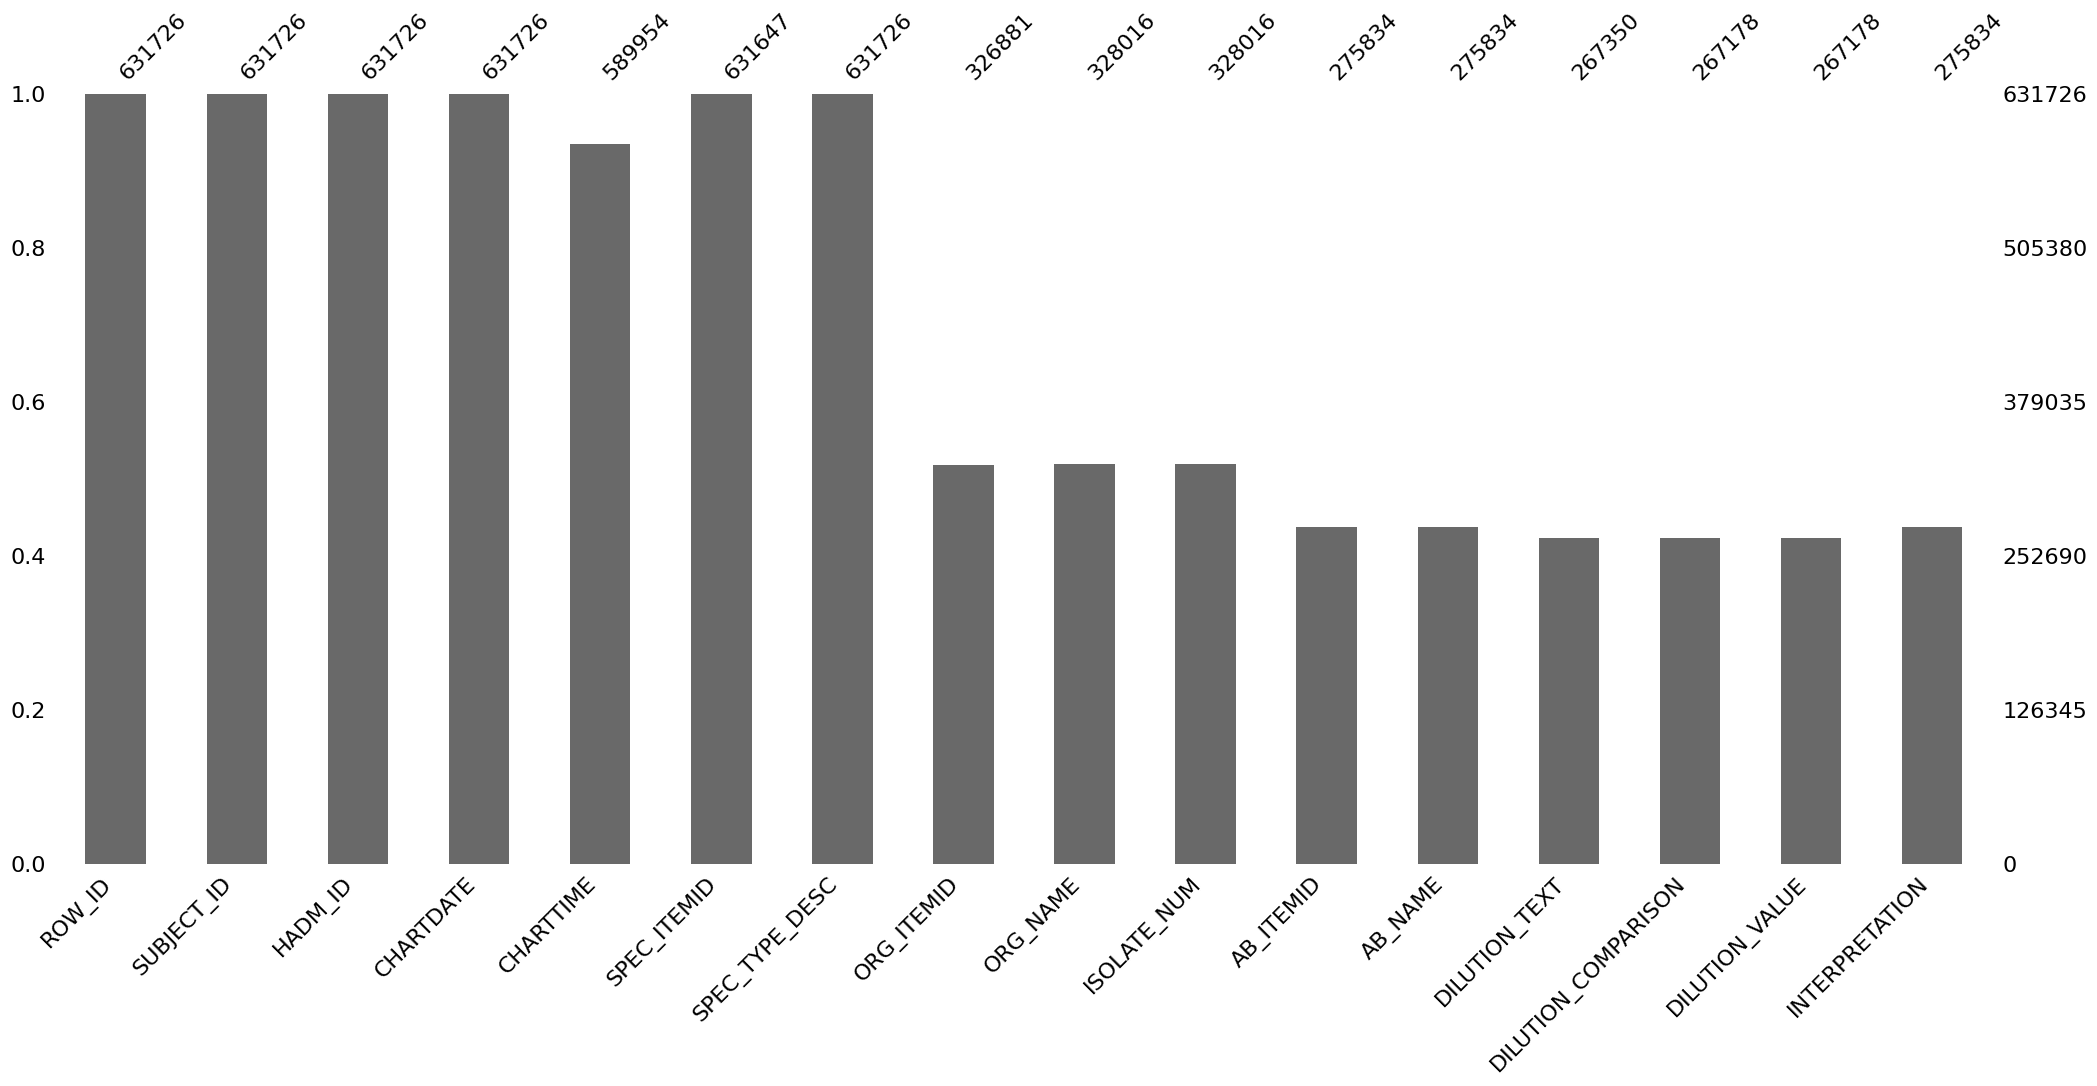

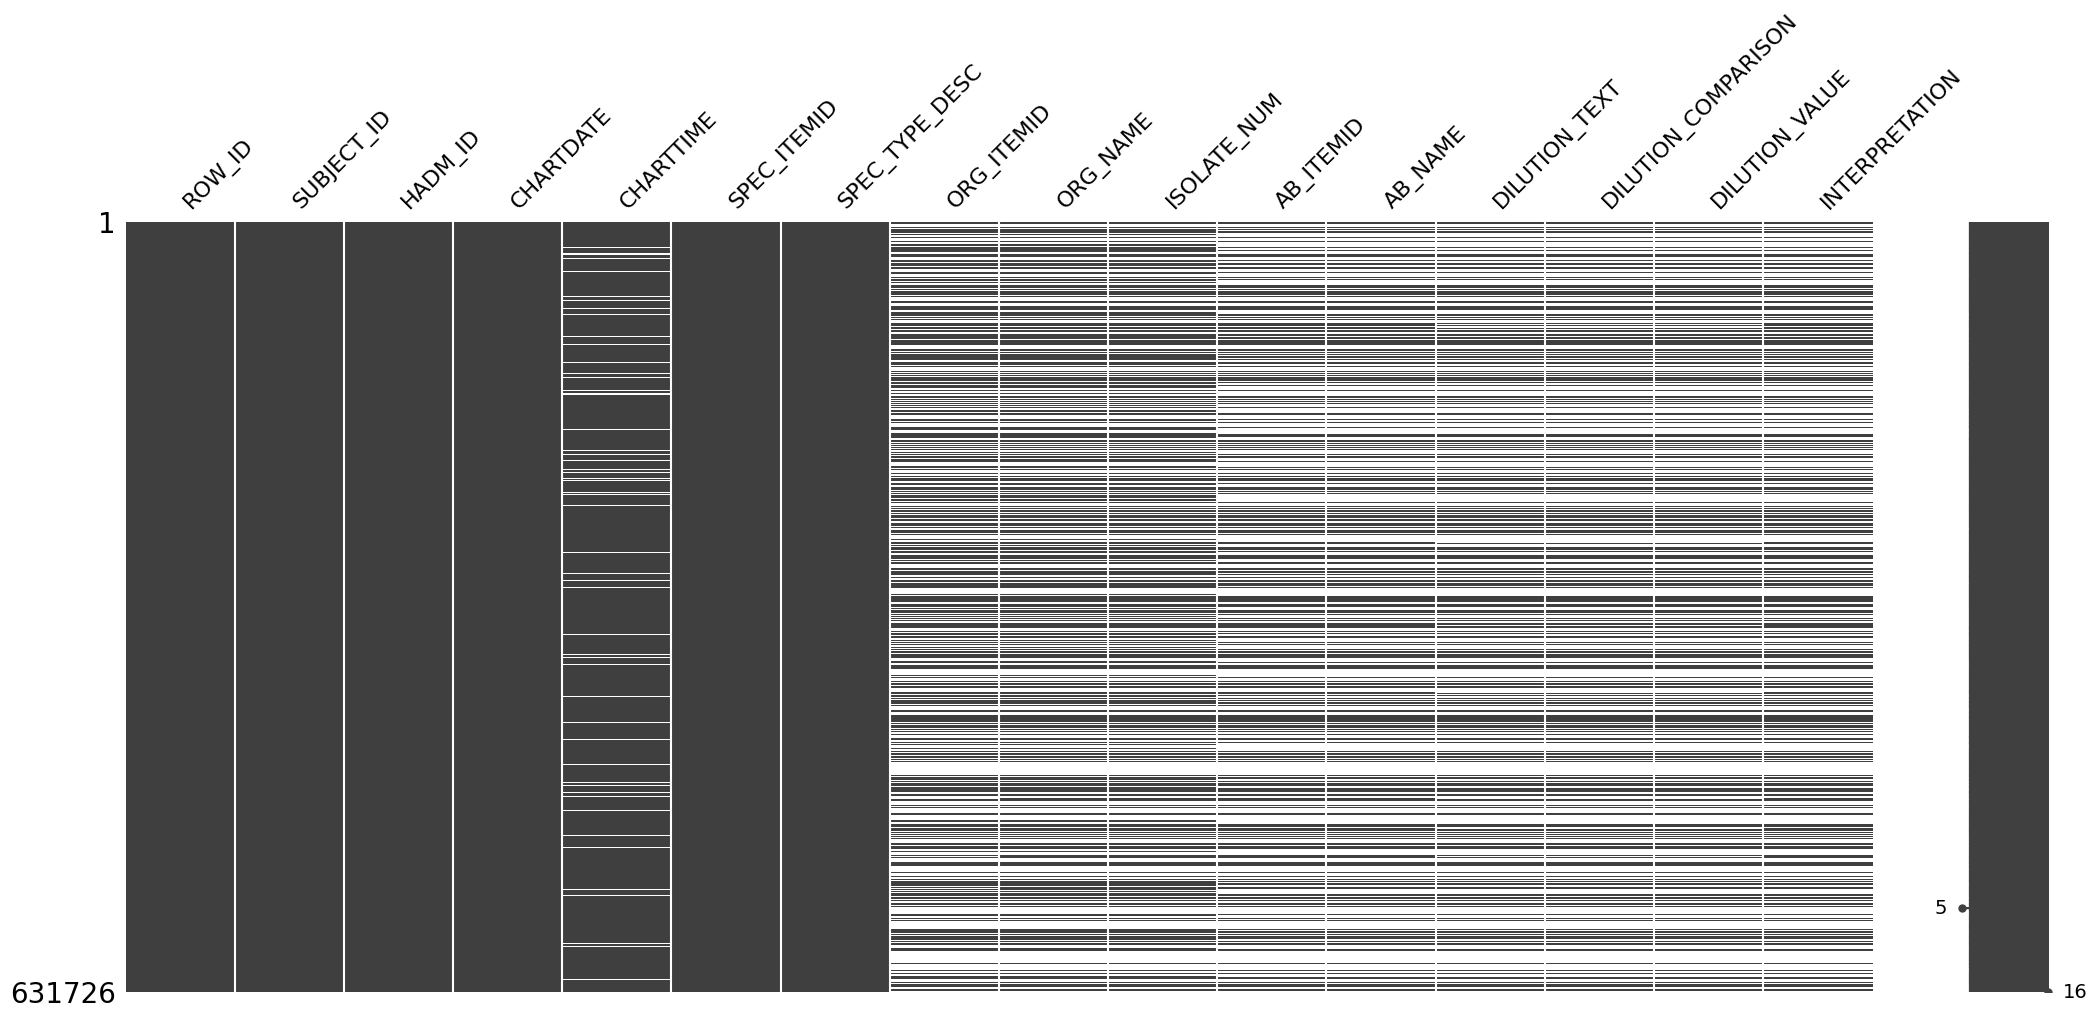

In [17]:
import missingno as msno
import matplotlib as plt
#msno.bar(df_microbiologyevents)
# plt.show()

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
def vizor_2(X_umap, X_pca, y):
    umap_df = pd.DataFrame({"Component_1": X_umap[:,0],
                       "Component_2": X_umap[:,1],
                       "Class": y})
    #
    ps_df = pd.DataFrame({"PC1": X_pca[:,0],
                       "PC2": X_pca[:,1],
                         "Class": y})
    #
    plt.figure(figsize=(14, 6))
    #
    plt.subplot(1, 2, 1)
    sns.scatterplot(x="Component_1", y="Component_2", hue="Class", data=umap_df, alpha=0.75, palette="Set1")
    plt.grid()
    plt.title('Groups on UMAP')
    #
    plt.subplot(1, 2, 2)
    sns.scatterplot(x="PC1", y="PC2", hue="Class", data=ps_df, alpha=0.75, palette="Set2")
    plt.grid()
    plt.title('Groups on PCA')
    #
    plt.show()

In [20]:
df_microbiologyevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
0,744,96,170324,2156-04-13 00:00:00,2156-04-13 14:18:00,70021.0,BRONCHOALVEOLAR LAVAGE,80026.0,PSEUDOMONAS AERUGINOSA,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,745,96,170324,2156-04-20 00:00:00,2156-04-20 13:10:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,746,96,170324,2156-04-20 00:00:00,2156-04-20 16:00:00,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,747,96,170324,2156-04-20 00:00:00,NaN,70012.0,BLOOD CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,748,96,170324,2156-04-20 00:00:00,NaN,70079.0,URINE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2.Sepsis Risk Predicting Model Implementation

## 2.1 Logistics Regression Model

In [14]:
df109451lab = df_labevents_s[df_labevents_s.HADM_ID==109451]


In [18]:
df109451admission = df_admissions[df_admissions.HADM_ID==109451]

df = pd.merge(df109451admission, df109451lab, on='HADM_ID', how='left')





In [20]:
df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])

df['time_diff'] = (df['CHARTTIME'] - df['ADMITTIME']).astype('timedelta64[m]')
filtered_df = df[df['time_diff'] <= 240] #first 4 hours

ValueError: Cannot convert from timedelta64[ns] to timedelta64[m]. Supported resolutions are 's', 'ms', 'us', 'ns'

## 2.2 Random Forest Model

## 2.3 Gradient Boosted Model

## 2.4 LSTM Model

## 2.5 LSTM + Attention Model

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation